In [771]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC

## 1. Load Data

In [729]:
df = pd.read_csv('./data/model_goalie_stats.csv')

In [731]:
df.drop(['season', 'name', 'team'], inplace = True, axis=1)

In [733]:
df.head()

,age,icetime,sv% on shots on goal,rebounds per save,freezes per save,% of shot attempts blocked by teammates,on goal % above expected,low danger unblocked shot attempt sv%,medium danger unblocked shot attempt sv%,high danger unblocked shot attempt sv% above expected,corsi,improvement
0,27,98154.0,0.924258,0.071982,0.266888,0.182874,0.021285,0.975585,0.884921,0.040395,75.811480,0.051340
1,21,180336.0,0.905486,0.082482,0.237956,0.211768,0.015651,0.971975,0.878378,-0.067372,71.925739,-0.125235
2,36,159763.0,0.886589,0.071895,0.230626,0.159748,0.018897,0.963744,0.864780,-0.072437,53.742105,-0.260870
3,28,108255.0,0.912355,0.086806,0.237269,0.200272,0.006053,0.967710,0.881517,0.040345,73.227103,-0.040179
4,28,202395.0,0.918218,0.053440,0.226658,0.189764,0.016701,0.969649,0.886836,-0.031238,70.205292,0.017932


In [735]:
# convert age to categorical variable
df_copy = df.copy() 

df_copy.loc[df_copy['age']  <  25, 'age']                             = 0
df_copy.loc[(df_copy['age'] >= 25)  & (df_copy['age']  < 29), 'age']  = 1
df_copy.loc[(df_copy['age'] >= 29)  & (df_copy['age']  < 34), 'age']  = 2
df_copy.loc[df_copy['age']  >= 34, 'age']                             = 3

# one-hot encode age variable
age_dummy = pd.get_dummies(df_copy['age'], prefix='age', dtype='int')
df_copy.drop('age', axis=1, inplace=True)
df_copy = pd.concat([age_dummy, df_copy], axis=1)

In [739]:
df_copy.shape

(720, 15)

## 2. Train-Test Split

In [742]:
np.random.seed(1234)

X = df_copy.drop('improvement', axis=1) 

# normalize features
scaler = StandardScaler()
X      = scaler.fit_transform(X)

y      = np.where(df['improvement'] <= 0, 0, 1)

# find one-hot encoded age columns
cols       = df_copy.columns.tolist()
age0_col   = cols.index('age_0')
age1_col   = cols.index('age_1')
age2_col   = cols.index('age_2')
age3_col   = cols.index('age_3')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=X[:, [age0_col, age1_col, age2_col, age3_col]])

In [744]:
print(X_train.shape, X_test.shape) # number of X train and X test samples
print(y_train.shape, y_test.shape) # number y train and y test samples

(576, 14) (144, 14)
(576,) (144,)


## 3. Define Performance Function

In [747]:
def performance(y_true, y_pred, metric="accuracy"):
    """
    Calculates the performance metric based on the agreement between the
    true labels and the predicted labels.

    Parameters
    --------------------
        y_true -- numpy array of shape (n,), known labels
        y_pred -- numpy array of shape (n,), (discrete-valued) predictions
        metric -- string, option used to select the performance measure
                  options: 'accuracy', 'f1-score', 'auroc', 'precision',
                           'sensitivity', 'specificity'

    Returns
    --------------------
        score  -- float, performance score
    """

    # compute classifier performance
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()

    scores = {
        'accuracy' : metrics.accuracy_score(y_true, y_pred),
        'f1-score' : metrics.f1_score(y_true, y_pred),
        'auroc' : metrics.roc_auc_score(y_true, y_pred),
        'precision' : metrics.precision_score(y_true, y_pred),
        'sensitivity' : metrics.recall_score(y_true, y_pred),
        'specificity' : tn / (tn + fp)
    }
    score = scores[metric]
    return score

# list possible metrics
metric_list = ["accuracy", "f1-score", "auroc", "precision", "sensitivity", "specificity"]

## 4. Modeling

### 4.1 K-NN

In [751]:
N        = 50
K        = np.arange(1,N+1)
splits   = 5
skf      = StratifiedKFold(n_splits = splits)
error    = np.zeros((N,splits))


for idx, k in enumerate(K):
    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        neigh  = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(X_train[train_index], y_train[train_index])
        y_pred = neigh.predict(X_train[test_index])
        error[idx][i] = 1 - np.mean(y_pred == y_train[test_index])
error = np.mean(error, axis=1)

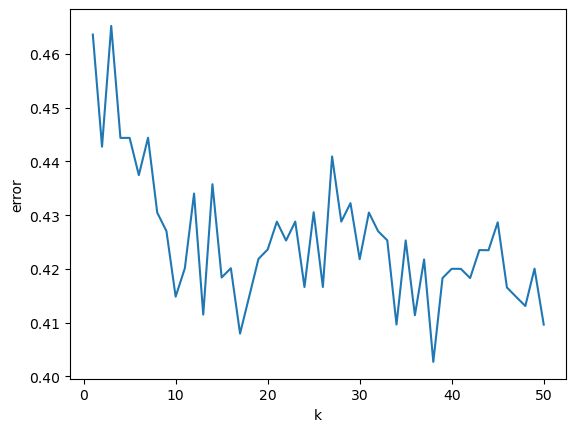

best k: 38


In [752]:
plt.plot(K, error)
plt.ylabel('error')
plt.xlabel('k')
plt.show()
best_k = K[np.min(error) == error][0]
print(f'best k: {best_k}')

In [755]:
best_k = K[np.min(error) == error][0] # find the best k (k = 38) 
neigh  = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
for metric in metric_list:
    print(f'metric: {metric}')
    print(round(performance(y_test, y_pred, metric), 3))
    print('----------------')

metric: accuracy
0.632
----------------
metric: f1-score
0.589
----------------
metric: auroc
0.631
----------------
metric: precision
0.655
----------------
metric: sensitivity
0.535
----------------
metric: specificity
0.726
----------------


### 4.2 Logistic Regression

In [758]:
C = np.array([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
splits   = 5
skf      = StratifiedKFold(n_splits = splits)
error    = np.zeros((len(C),splits))


for idx, c in enumerate(C):
    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        logit  = LogisticRegression(C=c, solver='liblinear', random_state=0)
        logit.fit(X_train[train_index], y_train[train_index])
        y_pred = logit.predict(X_train[test_index])
        error[idx][i] = 1 - np.mean(y_pred == y_train[test_index])
error = np.mean(error, axis=1)

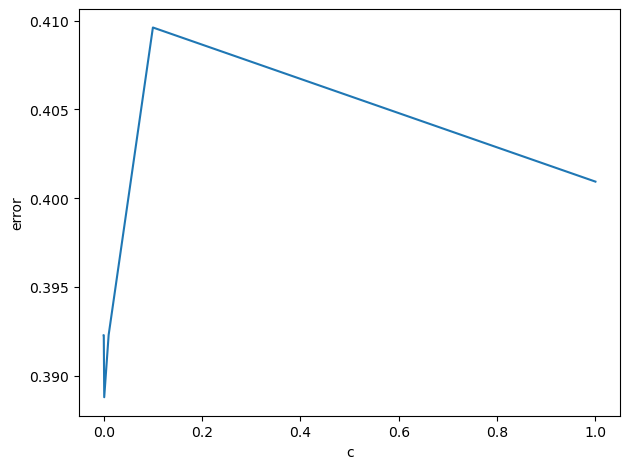

In [760]:
plt.plot(C, error)
plt.ylabel('error')
plt.xlabel('c')
plt.tight_layout()
plt.show()

In [762]:
best_c = C[np.min(error) == error][0] # find the best regularization parameter (lambda)
logit_best  = LogisticRegression(C=best_c, solver='liblinear')
logit_best.fit(X_train, y_train)
y_pred = logit_best.predict(X_test)
for metric in metric_list:
    print(f'metric: {metric}')
    print(round(performance(y_test, y_pred, metric), 3))
    print('----------------')

metric: accuracy
0.66
----------------
metric: f1-score
0.642
----------------
metric: auroc
0.659
----------------
metric: precision
0.667
----------------
metric: sensitivity
0.62
----------------
metric: specificity
0.699
----------------


### 4.3 SVM

In [765]:
C_range = 10.0 ** np.arange(-3, 3)

splits   = 5
skf      = StratifiedKFold(n_splits = splits)
error    = np.zeros((len(C),splits))


for idx, c in enumerate(C):
    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        clf  = LinearSVC(loss = 'hinge', random_state = 0, C=c, dual=True, max_iter = 100000)
        clf.fit(X_train[train_index], y_train[train_index])
        y_pred = clf.predict(X_train[test_index])
        error[idx][i] = 1 - np.mean(y_pred == y_train[test_index])
error = np.mean(error, axis=1)

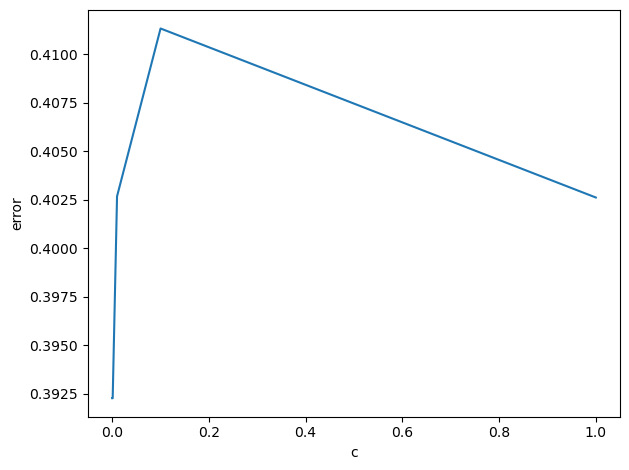

In [767]:
plt.plot(C, error)
plt.ylabel('error')
plt.xlabel('c')
plt.tight_layout()
plt.show()

In [769]:
best_c = C[np.min(error) == error][0] # find the best regularization parameter (lambda)
clf_best = LinearSVC(loss='hinge', random_state = 0, C=best_c, dual=True)
clf_best.fit(X_train, y_train)
y_pred = clf_best.predict(X_test)
for metric in metric_list:
    print(f'metric: {metric}')
    print(round(performance(y_test, y_pred, metric), 3))
    print('----------------')

metric: accuracy
0.667
----------------
metric: f1-score
0.652
----------------
metric: auroc
0.666
----------------
metric: precision
0.672
----------------
metric: sensitivity
0.634
----------------
metric: specificity
0.699
----------------
